In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Point, LineString, MultiLineString, Polygon, MultiPolygon
from tqdm.notebook import tqdm
import time
from datetime import datetime

import momepy as mm
import networkx as nx

import math

from contextlib import redirect_stdout

import io
import sys

from shapely.ops import nearest_points
from shapely.ops import unary_union

In [ ]:
# проверка остановки в буффере - если даже по вохдуху не попадает - не искать

In [2]:
graph = gpd.read_file('../lines_to_graph/with_ped/new_graph_with_ped.json',
                        encoding='utf-8')

In [3]:
nodes = gpd.read_file('../lines_to_graph/with_ped/all_nodes_with_ped.json',
                        encoding='utf-8')

In [4]:
buildings = gpd.read_file('./all_bui.json',encoding='utf-8')

In [5]:
stps_big = pd.read_csv('../lines_to_graph/total/df_stop_seq_all_n_samobl.csv',
                        encoding='utf-8', sep=';')

In [6]:
stps_big = stps_big[['stop_id', 'stop_name', 'lat', 'lon']]
stps_big = stps_big.drop_duplicates(subset=['stop_id']).reset_index(drop=True)

In [7]:
lst_geo=[]
lst_lat=list(stps_big.lat)
lst_lon=list(stps_big.lon)
i=0
for i in tqdm(range(len(stps_big))):
    one_pt = Point(lst_lon[i], lst_lat[i])
    lst_geo.append(one_pt)
# 

In [8]:
gdf_stops = gpd.GeoDataFrame(stps_big, geometry=lst_geo)
gdf_stops.crs='epsg:4326'

In [9]:
# убрать жд пути из графа
graph_ped = graph[graph.type_ped != 'no_ped'].reset_index(drop=True)[['link_id', 'geometry']]

In [10]:
shrt_bui = buildings[['osm_id', 'geometry']].copy()

In [11]:
def intersect_using_spatial_index(source_gdf, intersecting_gdf):
    """
    Conduct spatial intersection using spatial index for candidates GeoDataFrame to make queries faster.
    Note, with this function, you can have multiple Polygons in the 'intersecting_gdf' and it will return all the points
    intersect with ANY of those geometries.
    """
    source_sindex = source_gdf.sindex
    possible_matches_index = []

    # 'itertuples()' function is a faster version of 'iterrows()'
    for other in intersecting_gdf.itertuples():
        bounds = other.geometry.bounds
        c = list(source_sindex.intersection(bounds))
        possible_matches_index += c

    # Get unique candidates
    unique_candidate_matches = list(set(possible_matches_index))
    possible_matches = source_gdf.iloc[unique_candidate_matches]

    # Conduct the actual intersect
    result = possible_matches.loc[possible_matches.intersects(intersecting_gdf.unary_union)]
    return result
########

In [12]:
def find_closest_stop(gdf_one_bui, gdf_stops, gdf_buff):
    uu_stops = gdf_stops.geometry.unary_union
    centr_bui = gdf_one_bui.geometry[0].centroid
    nrst_pt = nearest_points(centr_bui, uu_stops)[1]
    
    nearest_stop_id = list(gdf_stops[gdf_stops.geometry == nrst_pt]['stop_id'])[0]
    nearest_stop_geo = list(gdf_stops[gdf_stops.geometry == nrst_pt]['geometry'])[0]
    if gdf_buff.geometry[0].intersects(nearest_stop_geo):
        return [nearest_stop_id, nearest_stop_geo]
    else:
        return []

In [13]:
def get_closest_node(gdf_obj, linkid, graph_in_buff):
    line_geo = list(graph_in_buff[graph_in_buff.link_id == linkid]['geometry'])[0]
    start = Point(line_geo.coords[0])
    end = Point(line_geo.coords[-1])
    obj_centr = gdf_obj['geometry'][0]#.centroid

    if start.distance(obj_centr) < end.distance(obj_centr):
        return start
    else:
        return end
# 

In [14]:
def get_shrt_pth(gdf_one_bui, gdf_buff, gdf_stops, graph_ped):

    try:
        nearest_stop = find_closest_stop(gdf_one_bui, gdf_stops, gdf_buff)
    except:
        nearest_stop = []
    #
    if nearest_stop != []:
        gdf_near_stop = gpd.GeoDataFrame(data=[nearest_stop], columns=['stop_id', 'geometry'])
        gdf_near_stop.crs=graph_ped.crs
        graph_in_buff = intersect_using_spatial_index(graph_ped, gdf_buff[['geometry']])
        centr_bui = gdf_one_bui.copy()
        centr_bui.geometry = centr_bui.geometry.centroid

        text_trap = io.StringIO()
        with redirect_stdout(text_trap):
            closest_link_bui = mm.get_network_id(gdf_one_bui, graph_in_buff, 'link_id')[0]
            closest_link_stop = mm.get_network_id(gdf_near_stop, graph_in_buff, 'link_id')[0]

        closest_node_bui = get_closest_node(gdf_one_bui, closest_link_bui, graph_in_buff)
        closest_node_stop = get_closest_node(gdf_near_stop, closest_link_stop, graph_in_buff)

        one_G = mm.gdf_to_nx(graph_in_buff)
        res_lst = nx.shortest_path(one_G, closest_node_bui.coords[0], closest_node_stop.coords[0])

        if len(res_lst) == 1:
            line_path = LineString([closest_node_bui, closest_node_stop])
            path_lngth = 0
        elif len(res_lst) == 0:
            line_path = LineString([closest_node_bui, closest_node_stop])
            path_lngth = -1
        else:
            line_path = LineString(res_lst)
            path_lngth = 1
    # 
        return [nearest_stop[0], path_lngth, res_lst, line_path]
    else:
        return []

In [15]:
# list(shrt_bui.osm_id).index(40707382)

In [15]:
np_shbu = shrt_bui.to_numpy()
ind_oi_bui = list(shrt_bui.columns).index('osm_id')
ind_geo_bui = list(shrt_bui.columns).index('geometry')

In [16]:
lst_total_path = []
i=0
# for i in tqdm(range(len(np_shbu))):
for i in tqdm(range(2)):
    one_bui_oi = np_shbu[i, ind_oi_bui]
    one_bui_geo = np_shbu[i, ind_geo_bui]
    
    gdf_one_bui = gpd.GeoDataFrame(geometry=[one_bui_geo])
    gdf_one_bui.crs = 'epsg:4326'

    gdf_buff = gdf_one_bui.copy()
    gdf_buff.geometry = gdf_buff.geometry.to_crs('epsg:32637').buffer(1000).to_crs('epsg:4326')
    
    lst_path = get_shrt_pth(gdf_one_bui, gdf_buff, gdf_stops, graph_ped)
    
    if lst_path != []:
        lst_total_path.append([one_bui_oi] + lst_path)
    #
# 

C:\Users\ochristm\anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  del sys.path[0]
C:\Users\ochristm\anaconda3\lib\site-packages\momepy\elements.py:696: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buildings_c["geometry"] = buildings_c.centroid  # make centroids
Snapping: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.02it/s]
C:\Users\ochristm\anaconda3\lib\site-packages\momepy\utils.py:202: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_netwo

In [18]:
gdf_path = gpd.GeoDataFrame(lst_total_path, 
                            columns = ['osm_id_bui','stop_id_ya',
                                       'is_valid', 'node_seq', 'geometry'])
gdf_path.crs = graph_ped.crs

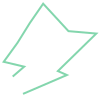

In [19]:
gdf_path.geometry[0]

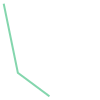

In [20]:
gdf_path.geometry[1]

In [21]:
gdf_path

,osm_id_bui,stop_id_ya,is_valid,node_seq,geometry
0,18593990,stop__10001048,1,"[(50.1937811, 53.238617), (50.194359, 53.23911...","LINESTRING (50.19378 53.23862, 50.19436 53.239..."
1,21759242,stop__10001436,1,"[(50.1975432, 53.2259105), (50.1976047, 53.225...","LINESTRING (50.19754 53.22591, 50.19760 53.225..."


In [25]:
centr_bui = shrt_bui.iloc[[0]].copy()


In [26]:
centr_bui.geometry = centr_bui.geometry.centroid

C:\Users\ochristm\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


In [32]:
graph_notdir = graph[graph.direction == 'direct'].reset_index(drop=True)

In [33]:
len(graph)

246748

In [34]:
len(graph_notdir)

123374

In [35]:
graph_in_buff = intersect_using_spatial_index(graph_notdir, gdf_buff[['geometry']])

In [ ]:
mm.gdf_to_nx(graph_in_buff)

In [ ]:
nx.ego_graph(G, largest_hub)

In [17]:
# def get_shrt_pth(gdf_one_bui, gdf_buff, gdf_stops, graph_ped):

try:
    nearest_stop = find_closest_stop(gdf_one_bui, gdf_stops, gdf_buff)
except:
    nearest_stop = []
#
if nearest_stop != []:
    gdf_near_stop = gpd.GeoDataFrame(data=[nearest_stop], columns=['stop_id', 'geometry'])
    gdf_near_stop.crs=graph_ped.crs
    graph_in_buff = intersect_using_spatial_index(graph_ped, gdf_buff[['geometry']])
    centr_bui = gdf_one_bui.copy()
    centr_bui.geometry = centr_bui.geometry.centroid

    text_trap = io.StringIO()
    with redirect_stdout(text_trap):
        closest_link_bui = mm.get_network_id(gdf_one_bui, graph_in_buff, 'link_id')[0]
        closest_link_stop = mm.get_network_id(gdf_near_stop, graph_in_buff, 'link_id')[0]

    closest_node_bui = get_closest_node(gdf_one_bui, closest_link_bui, graph_in_buff)
    closest_node_stop = get_closest_node(gdf_near_stop, closest_link_stop, graph_in_buff)

    one_G = mm.gdf_to_nx(graph_in_buff)
    res_lst = nx.shortest_path(one_G, closest_node_bui.coords[0], closest_node_stop.coords[0])

    if len(res_lst) == 1:
        line_path = LineString([closest_node_bui, closest_node_stop])
        path_lngth = 0
    elif len(res_lst) == 0:
        line_path = LineString([closest_node_bui, closest_node_stop])
        path_lngth = -1
    else:
        line_path = LineString(res_lst)
        path_lngth = 1
# 
#     return [nearest_stop[0], path_lngth, res_lst, line_path]
# else:
#     return []

C:\Users\ochristm\anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  del sys.path[0]
C:\Users\ochristm\anaconda3\lib\site-packages\momepy\elements.py:696: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buildings_c["geometry"] = buildings_c.centroid  # make centroids
Snapping: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.39it/s]
C:\Users\ochristm\anaconda3\lib\site-packages\momepy\utils.py:202: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_netwo

In [ ]:
one_G = mm.gdf_to_nx(graph_in_buff)

In [18]:
tmp_gdf = graph[((graph.direction == 'direct') 
                 & (graph.link_id.isin(graph_in_buff.link_id)))].reset_index(drop=True)
tmp_gdf = tmp_gdf[['link_id', 'geometry']]
tmp_gdf = tmp_gdf.to_crs('epsg:32640')

In [103]:
# tmp_gdf = graph_in_buff.copy()
# tmp_gdf = tmp_gdf.to_crs('epsg:32640')

In [117]:
two_G = mm.gdf_to_nx(tmp_gdf)

In [105]:
one_pt = gpd.GeoDataFrame(geometry=[closest_node_bui])
one_pt.crs='epsg:4326'
one_pt = one_pt.to_crs('epsg:32640')

In [118]:
egg2 = nx.ego_graph(two_G, one_pt.geometry[0].coords[0], radius = 10)
# egg = nx.ego_graph(one_G, closest_node_bui.coords[0])

In [119]:
gdf_ego_nodes, gdf_ego_edges = mm.nx_to_gdf(egg2)

In [120]:
gdf_ego_edges2 = gdf_ego_edges.copy()
gdf_ego_edges2 = gdf_ego_edges2.to_crs('epsg:4326')

In [94]:
# graph_in_buff.to_file('graph_in_buff.json', driver='GeoJSON', encoding='utf-8')

In [121]:
gdf_ego_edges2.to_file('gdf_ego_edges103.json', driver='GeoJSON', encoding='utf-8')

In [24]:
edges = graph[graph.link_id.isin(tmp_gdf.link_id)][['link_id',
                                                    'from_node', 
                                                    'to_node', 
                                                    'geometry']].reset_index(drop=True)
edges = edges.to_crs('epsg:32640')

In [26]:
edges['length'] = edges['geometry'].apply(lambda x: x.length if x!=None else None)

In [89]:
edges2 = graph[graph.direction == 'direct'][['link_id',
                                                    'from_node', 
                                                    'to_node', 
                                                    'geometry']].reset_index(drop=True)
edges2 = edges2.to_crs('epsg:32640')
edges2['length'] = edges2['geometry'].apply(lambda x: x.length if x!=None else None)

In [92]:
%time G2 = mm.gdf_to_nx(edges)

Wall time: 210 ms


In [99]:
%time G2 = mm.gdf_to_nx(edges2)

Wall time: 31 s


In [103]:
edges3 = graph[['link_id',
                'from_node', 
                'to_node', 
                'geometry']].reset_index(drop=True)
edges3 = edges3.to_crs('epsg:32640')
%time edges3['length'] = edges3['geometry'].apply(lambda x: x.length if x!=None else None)

Wall time: 832 ms


In [104]:
%time G3 = mm.gdf_to_nx(edges3)

Wall time: 1min 3s


In [ ]:
def _generate_primal(G, gdf_network, fields):
    """
    Generate primal graph.
    Helper for gdf_to_nx.
    """
    G.graph["approach"] = "primal"
    key = 0
    for index, row in gdf_network.iterrows():
        first = row.geometry.coords[0]
        last = row.geometry.coords[-1]

        data = [row[f] for f in fields]
        attributes = dict(zip(fields, data))
        G.add_edge(first, last, key=key, **attributes)
        key += 1

In [111]:
G = nx.Graph()
fields = list(edges.columns)
key = 0
for index, row in edges.iterrows():
    first = row.from_node
    last = row.to_node

    data = [row[f] for f in fields]
    attributes = dict(zip(fields, data))
    G.add_edge(first, last, key=key, **attributes)
    key += 1

In [85]:
# Создаем двунаправленый граф из полученных связей с весом по длине
G = nx.Graph()
for i in tqdm(range(len(edges))):
    G.add_edge(edges.from_node[i],edges.to_node[i], weight = edges.length[i])

In [30]:
nodes[nodes.geometry == closest_node_bui]

,nodeID,geometry
23360,23361,POINT (50.19754 53.22591)


In [55]:
# nodes[nodes.geometry == closest_node_bui].to_file('one_pt.json', 
#                                                   driver='GeoJSON', encoding='utf-8')

In [100]:
%time egg = nx.ego_graph(G, 23361, radius  = 500, distance = 'weight')

Wall time: 0 ns


In [112]:
%time egg2 = nx.ego_graph(G, 23361, radius  = 500, distance = 'weight')

Wall time: 17.1 ms


In [87]:
lst_nodes_end=[]
lst_nodes = list(egg.nodes())
i=0
for i in tqdm(range(len(lst_nodes))):
    one_node = lst_nodes[i]
    lst_neigh = list(nx.all_neighbors(egg, one_node))
    if len(lst_neigh) < 2:
        lst_nodes_end.append(one_node)
# 

In [88]:
lst_nodes_end

[23056,
 22819,
 22834,
 23361,
 81855,
 23110,
 22599,
 23881,
 23118,
 23120,
 22601,
 34517,
 23002,
 23011,
 23024,
 22642,
 23419]

In [75]:
i=0
one_node = list(G.nodes())[i]

In [76]:
lst_neigh = list(nx.all_neighbors(G, one_node))

In [77]:
lst_neigh

[23516, 22561, 23522]

In [78]:
one_node

22560

In [65]:
G.out_degree(23361)==0

True

In [67]:
G.out_edges(23361)

OutEdgeDataView([])

In [ ]:
#  для обрезки:
# начало - всегда одно и то же
# найти концы - нет соседей?
# на концах найти следующее ребро, которого нет в эго
# построить кратчайший путь от начала до конца
# из последовательности сделать линию
# обрезать линию по длине

In [ ]:
nx.DiGraph.

In [113]:
edglst = nx.to_pandas_edgelist(egg2)

In [115]:
edglst

,source,target,key,length,link_id,to_node,from_node,geometry
0,22560,22561,0,52.760971,59465,22561,22560,LINESTRING (46796.10503889964 5918621.23327252...
1,22560,23516,1,23.879154,59467,22560,23516,LINESTRING (46806.58414868481 5918599.77628603...
2,22560,23522,2,30.592961,59469,23522,22560,LINESTRING (46796.10503889964 5918621.23327252...
3,22561,22761,3,9.809393,59471,22561,22761,LINESTRING (46767.77717094606 5918664.77210017...
4,22561,22762,4,87.640065,59473,22762,22561,LINESTRING (46776.08731119713 5918669.98417814...
...,...,...,...,...,...,...,...,...
717,83202,83203,732,125.081038,220111,83203,83202,LINESTRING (45703.22876603779 5919999.40098003...
718,83202,83241,733,77.670292,220113,83241,83202,LINESTRING (45703.22876603779 5919999.40098003...
719,83110,83447,724,96.074388,219863,83447,83110,LINESTRING (46448.95758824947 5920006.66832870...
720,83447,83261,734,93.336159,220263,83261,83447,LINESTRING (46513.65671963873 5920077.69163835...


In [114]:
edglst2 = edglst.merge(graph[['link_id','from_node', 'to_node','geometry']], 
                       how='left', left_on=['source', 'target'], 
                      right_on=['from_node', 'to_node'])

edglst2 = gpd.GeoDataFrame(edglst2, geometry='geometry')
edglst2.crs='epsg:4326'

ValueError: Unknown column geometry

In [42]:
edges[((edges.from_node == 22913) | (edges.to_node == 22891))]

,link_id,from_node,to_node,geometry,length
33,59837,22636,22891,"LINESTRING (46313.241 5918772.751, 46296.889 5...",29.984755
130,60819,22913,22914,"LINESTRING (46382.844 5918845.626, 46401.145 5...",196.018496
131,60821,22913,23110,"LINESTRING (46382.844 5918845.626, 46461.905 5...",93.087539


In [53]:
edglst2.to_file('ego500.json', driver='GeoJSON', encoding='utf-8')

In [54]:
edges.to_file('edges.json', driver='GeoJSON', encoding='utf-8')

In [ ]:
def gdf_to_nx(gdf_network, approach="primal", length="mm_len"):
    """
    Convert LineString GeoDataFrame to networkx.MultiGraph
    Parameters
    ----------
    gdf_network : GeoDataFrame
        GeoDataFrame containing objects to convert
    approach : str, default 'primal'
        Decide wheter genereate ``'primal'`` or ``'dual'`` graph.
    length : str, default mm_len
        name of attribute of segment length (geographical) which will be saved to graph
    Returns
    -------
    networkx.Graph
        Graph
    """
    gdf_network = gdf_network.copy()
    if "key" in gdf_network.columns:
        gdf_network.rename(columns={"key": "__key"}, inplace=True)
    # generate graph from GeoDataFrame of LineStrings
    net = nx.MultiGraph()
    net.graph["crs"] = gdf_network.crs
    gdf_network[length] = gdf_network.geometry.length
    fields = list(gdf_network.columns)

    if approach == "primal":
        _generate_primal(net, gdf_network, fields)

    elif approach == "dual":
        _generate_dual(net, gdf_network, fields)

    else:
        raise ValueError(
            "Approach {} is not supported. Use 'primal' or 'dual'.".format(approach)
        )

    return net

In [ ]:
def _generate_primal(G, gdf_network, fields):
    """
    Generate primal graph.
    Helper for gdf_to_nx.
    """
    G.graph["approach"] = "primal"
    key = 0
    for index, row in gdf_network.iterrows():
        first = row.geometry.coords[0]
        last = row.geometry.coords[-1]

        data = [row[f] for f in fields]
        attributes = dict(zip(fields, data))
        G.add_edge(first, last, key=key, **attributes)
        key += 1